# Project 1

## Business Questions

	1. Are developers able to achieve salary progression through years of service?
	    - what is the correlation to their demographics?
	2. Which developers should employers target for the best value-for-money, and where?
	3. How well can we predict experience based on Salary/Expected Salary and programming skills? 

# Explore the dataset
First, we load the required libraries and explore a bit the dataset, looking for: how many answers we have, data-points (columns) and so on.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.metrics import r2_score, mean_squared_error
# import AllTogether as t
import seaborn as sns
%matplotlib inline

from google.colab import drive
drive.mount('/content/drive')

df = pd.read_csv('drive/My Drive/Colab Notebooks/survey_results_public.csv')
df

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


,Respondent,MainBranch,Hobbyist,OpenSourcer,OpenSource,Employment,Country,Student,EdLevel,UndergradMajor,EduOther,OrgSize,DevType,YearsCode,Age1stCode,YearsCodePro,CareerSat,JobSat,MgrIdiot,MgrMoney,MgrWant,JobSeek,LastHireDate,LastInt,FizzBuzz,JobFactors,ResumeUpdate,CurrencySymbol,CurrencyDesc,CompTotal,CompFreq,ConvertedComp,WorkWeekHrs,WorkPlan,WorkChallenge,WorkRemote,WorkLoc,ImpSyn,CodeRev,CodeRevHrs,...,DatabaseWorkedWith,DatabaseDesireNextYear,PlatformWorkedWith,PlatformDesireNextYear,WebFrameWorkedWith,WebFrameDesireNextYear,MiscTechWorkedWith,MiscTechDesireNextYear,DevEnviron,OpSys,Containers,BlockchainOrg,BlockchainIs,BetterLife,ITperson,OffOn,SocialMedia,Extraversion,ScreenName,SOVisit1st,SOVisitFreq,SOVisitTo,SOFindAnswer,SOTimeSaved,SOHowMuchTime,SOAccount,SOPartFreq,SOJobs,EntTeams,SOComm,WelcomeChange,SONewContent,Age,Gender,Trans,Sexuality,Ethnicity,Dependents,SurveyLength,SurveyEase
0,1,I am a student who is learning to code,Yes,Never,The quality of OSS and closed source software ...,"Not employed, and not looking for work",United Kingdom,No,Primary/elementary school,NaN,"Taught yourself a new language, framework, or ...",NaN,NaN,4,10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,SQLite,MySQL,MacOS;Windows,Android;Arduino;Windows,Django;Flask,Flask;jQuery,Node.js,Node.js,IntelliJ;Notepad++;PyCharm,Windows,I do not use containers,NaN,NaN,Yes,"Fortunately, someone else has that title",Yes,Twitter,Online,Username,2017,A few times per month or weekly,Find answers to specific questions;Learn how t...,3-5 times per week,Stack Overflow was much faster,31-60 minutes,No,NaN,"No, I didn't know that Stack Overflow had a jo...","No, and I don't know what those are",Neutral,Just as welcome now as I felt last year,Tech articles written by other developers;Indu...,14.0,Man,No,Straight / Heterosexual,NaN,No,Appropriate in length,Neither easy nor difficult
1,2,I am a student who is learning to code,No,Less than once per year,The quality of OSS and closed source software ...,"Not employed, but looking for work",Bosnia and Herzegovina,"Yes, full-time","Secondary school (e.g. American high school, G...",NaN,Taken an online course in programming or softw...,NaN,"Developer, desktop or enterprise applications;...",NaN,17,NaN,NaN,NaN,NaN,NaN,NaN,I am actively looking for a job,I've never had a job,NaN,NaN,Financial performance or funding status of the...,"Something else changed (education, award, medi...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,MySQL,Windows,Windows,Django,Django,NaN,NaN,Atom;PyCharm,Windows,I do not use containers,NaN,Useful across many domains and could change ma...,Yes,Yes,Yes,Instagram,Online,Username,2017,Daily or almost daily,Find answers to specific questions;Learn how t...,3-5 times per week,Stack Overflow was much faster,11-30 minutes,Yes,A few times per month or weekly,"No, I knew that Stack Overflow had a job board...","No, and I don't know what those are","Yes, somewhat",Just as welcome now as I felt last year,Tech articles written by other developers;Indu...,19.0,Man,No,Straight / Heterosexual,NaN,No,Appropriate in length,Neither easy nor difficult
2,3,"I am not primarily a developer, but I write co...",Yes,Never,The quality of OSS and closed source software ...,Employed full-time,Thailand,No,"Bachelor’s degree (BA, BS, B.Eng., etc.)",Web development or web design,"Taught yourself a new language, framework, or ...",100 to 499 employees,"Designer;Developer, back-end;Developer, front-...",3,22,1,Slightly satisfied,Slightly satisfied,Not at all confident,Not sure,Not sure,"I’m not actively looking, but I am open to new...",1-2 years ago,Interview with people in peer roles,No,"Languages, frameworks, and other technologies ...",I was preparing for a job search,THB,Thai baht,23000.0,Monthly,8820.0,40.0,There's no schedule or spec; I work on what se...,Distracting work environment;Inadequate access...,Less than once per month / Never

#### Unique `MainBranch` responses:

In [2]:
# df.describe()
df.MainBranch.unique()

array(['I am a student who is learning to code',
       'I am not primarily a developer, but I write code sometimes as part of my work',
       'I am a developer by profession', 'I code primarily as a hobby',
       'I used to be a developer by profession, but no longer am', nan],
      dtype=object)

## 1. Are developers able to achieve salary progression through years of service?
* what is the correlation to their demographics?

In this section, we're interested in the professional developers exclusively. Those who have been but today are might also be of interest since we may be able to analyse their progression even if, we may not be able to correlate how desirable they are as programmers.

From the DataSet: we know we're starting with 88883 responses.

#### Dropping everyone that is not a i) Professional developer and ii) used to be a developer. We also clean the answers of those who did not respond to such questions of course.

In [3]:
df = df.dropna(axis=0, how="any", subset=['MainBranch']) # Dropping 2 non-respondents

# Dropping types of coders but the professional, current or past:
df = df[df.MainBranch != "I am a student who is learning to code"]
df = df[df.MainBranch != "I am not primarily a developer, but I write code sometimes as part of my work"]
df = df[df.MainBranch != "I code primarily as a hobby"]

# Dropping responses if they do not include salary or years of coding:
df = df.dropna(axis=0, how="any", subset=['Age', 'Country', 'ConvertedComp', 'YearsCode', 'YearsCodePro'])
df

,Respondent,MainBranch,Hobbyist,OpenSourcer,OpenSource,Employment,Country,Student,EdLevel,UndergradMajor,EduOther,OrgSize,DevType,YearsCode,Age1stCode,YearsCodePro,CareerSat,JobSat,MgrIdiot,MgrMoney,MgrWant,JobSeek,LastHireDate,LastInt,FizzBuzz,JobFactors,ResumeUpdate,CurrencySymbol,CurrencyDesc,CompTotal,CompFreq,ConvertedComp,WorkWeekHrs,WorkPlan,WorkChallenge,WorkRemote,WorkLoc,ImpSyn,CodeRev,CodeRevHrs,...,DatabaseWorkedWith,DatabaseDesireNextYear,PlatformWorkedWith,PlatformDesireNextYear,WebFrameWorkedWith,WebFrameDesireNextYear,MiscTechWorkedWith,MiscTechDesireNextYear,DevEnviron,OpSys,Containers,BlockchainOrg,BlockchainIs,BetterLife,ITperson,OffOn,SocialMedia,Extraversion,ScreenName,SOVisit1st,SOVisitFreq,SOVisitTo,SOFindAnswer,SOTimeSaved,SOHowMuchTime,SOAccount,SOPartFreq,SOJobs,EntTeams,SOComm,WelcomeChange,SONewContent,Age,Gender,Trans,Sexuality,Ethnicity,Dependents,SurveyLength,SurveyEase
3,4,I am a developer by profession,No,Never,The quality of OSS and closed source software ...,Employed full-time,United States,No,"Bachelor’s degree (BA, BS, B.Eng., etc.)","Computer science, computer engineering, or sof...",Taken an online course in programming or softw...,100 to 499 employees,"Developer, full-stack",3,16,Less than 1 year,Very satisfied,Slightly satisfied,Very confident,No,Not sure,I am not interested in new job opportunities,Less than a year ago,"Write code by hand (e.g., on a whiteboard);Int...",No,"Languages, frameworks, and other technologies ...",I was preparing for a job search,USD,United States dollar,61000.0,Yearly,61000.0,80.00,There's no schedule or spec; I work on what se...,NaN,Less than once per month / Never,Home,A little below average,No,NaN,...,MySQL;SQLite,MySQL;SQLite,Linux;Windows,Linux;Windows,NaN,NaN,.NET,.NET,Eclipse;Vim;Visual Studio;Visual Studio Code,Windows,I do not use containers,Not at all,"Useful for decentralized currency (i.e., Bitcoin)",Yes,SIGH,Yes,Reddit,In real life (in person),Username,2014,Daily or almost daily,Find answers to specific questions;Pass the ti...,1-2 times per week,Stack Overflow was much faster,31-60 minutes,Yes,Less than once per month or monthly,Yes,"No, and I don't know what those are","No, not really",Just as welcome now as I felt last year,Tech articles written by other developers;Indu...,22.0,Man,No,Straight / Heterosexual,White or of European descent,No,Appropriate in length,Easy
8,9,I am a developer by profession,Yes,Once a month or more often,The quality of OSS and closed source software ...,Employed full-time,New Zealand,No,Some college/university study without earning ...,"Computer science, computer engineering, or sof...",Taken an online course in programming or softw...,10 to 19 employees,"Database administrator;Developer, back-end;Dev...",12,11,4,Slightly satisfied,Slightly satisfied,Somewhat confident,No,Not sure,"I’m not actively looking, but I am open to new...",Less than a year ago,Write any code;Interview with people in peer r...,Yes,Financial performance or funding status of the...,I was preparing for a job search,NZD,New Zealand dollar,138000.0,Yearly,95179.0,32.00,There is a schedule and/or spec (made by me or...,Being tasked with non-development work;Inadequ...,Less than once per month / Never,Office,A little above average,"Yes, because I see value in code review",12.0,...,DynamoDB;PostgreSQL;SQLite,PostgreSQL;Redis;SQLite,AWS;Docker;Heroku;Linux;MacOS;Slack,AWS;Docker;Heroku;Linux;MacOS;Slack;Other(s):,Express;Ruby on Rails;Other(s):,Express;Ruby on Rails;Other(s):,Node.js;Unity 3D,Node.js,Vim,MacOS,Development;Testing;Production,Not at all,An irresponsible use of resources,No,SIGH,Yes,Twitter,In real life (in person),Username,2013,Daily or almost daily,Find answers to specific questions;Contribute ...,3-5 times per week,They were about the same,NaN,Yes,Less than once per month or monthly,"No, I knew that Stack Overflow had a job board...","No, and I don't know what those are","Yes, somewhat",Just as welcome now as I felt last year,NaN,23

We have **48350** responses from all current or past professional developers (who provided info on their age & country).

#### Let's focus on the parameters we want to track:

In [4]:
df = df[['Age', 'Gender', 'Dependents', 'Country', 'ConvertedComp', 'YearsCode', 'Age1stCode', 'YearsCodePro', 'MainBranch', 'DevType', 'Employment', 'EdLevel', 'UndergradMajor', 'EduOther']]
df

,Age,Gender,Dependents,Country,ConvertedComp,YearsCode,Age1stCode,YearsCodePro,MainBranch,DevType,Employment,EdLevel,UndergradMajor,EduOther
3,22.0,Man,No,United States,61000.0,3,16,Less than 1 year,I am a developer by profession,"Developer, full-stack",Employed full-time,"Bachelor’s degree (BA, BS, B.Eng., etc.)","Computer science, computer engineering, or sof...",Taken an online course in programming or softw...
8,23.0,Man,No,New Zealand,95179.0,12,11,4,I am a developer by profession,"Database administrator;Developer, back-end;Dev...",Employed full-time,Some college/university study without earning ...,"Computer science, computer engineering, or sof...",Taken an online course in programming or softw...
12,28.0,Man,Yes,United States,90000.0,17,11,8,I am a developer by profession,Data or business analyst;Database administrato...,Employed full-time,"Master’s degree (MA, MS, M.Eng., MBA, etc.)","Computer science, computer engineering, or sof...",Taken an online course in programming or softw...
13,31.0,Man,No,Germany,57060.0,13,16,2,I am a developer by profession,"Developer, desktop or enterprise applications",Employed full-time,"Other doctoral degree (Ph.D, Ed.D., etc.)","Computer science, computer engineering, or sof...",Completed an industry certification program (e...
15,26.0,Man,No,United Kingdom,455352.0,10,17,3,I am a developer by profession,"Developer, full-stack",Employed full-time,"Master’s degree (MA, MS, M.Eng., MBA, etc.)",NaN,Taken an online course in programming or softw...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
88324,48.0,Man,Yes,United States,2000000.0,31,18,28,I am a developer by profession,Data scientist or machine learning specialist;...,Employed full-time,"Bachelor’s degree (BA, BS, B.Eng., etc.)","Computer science, computer engineering, or sof...",Taken an online course in programming or softw...
88325,26.0,Man,No,United States,130000.0,12,14,3,I am a developer by profession,"Developer, back-end;Developer, front-end;Devel...",Employed full-time,"Bachelor’s degree (BA, BS, B.Eng., etc.)","Computer science, computer engineering, or sof...",Taken an online course in programming or softw...
88326,34.0,Man,No,Finland,82488.0,17,16,7,I am a developer by profession,"Developer, desktop or enterprise applications;...",Employed full-time,"Master’s degree (MA, MS, M.Eng., MBA, etc.)","Computer science, computer engineering, or sof...","Taught yourself a new language, framework, or ..."
88328,37.0,Man,No,Austria,68745.0,18,17,9,I am a developer by profession,"Developer, full-stack;Engineer, site reliability",Employed full-time,"Master’s degree (MA, MS, M.Eng., MBA, etc.)","Computer science, computer engineering, or sof...",Taken an online course in programming or softw...


In [5]:
df.YearsCodePro.unique()

array(['Less than 1 year', '4', '8', '2', '3', '13', '18', '1', '14',
       '22', '23', '19', '20', '10', '9', '7', '5', '48', '12', '31',
       '11', '6', '17', '15', '16', '21', '26', '30', '25', '33', '35',
       '37', '29', '28', '34', '27', '24', '40', '32', '45', '44', '36',
       '43', '41', '39', '42', '50', '38', 'More than 50 years', '47',
       '46', '49'], dtype=object)

We further clean values for the responses for bottom and upper range.
So we transform 'Less than 1 year' into '1' and 'More than 50 years' into '50'

* Is this something we can do without skewing the data?
Let's find out.

In [6]:
(df.YearsCode == 'Less than 1 year').value_counts()
(df.YearsCode == 'Less than 1 year').value_counts() / df.YearsCode.count()
# So 130 responses are for 'Less than 1 year' and this is ~0.0026% of total.

(df.YearsCode == 'More than 50 years').value_counts()
(df.YearsCode == 'More than 50 years').value_counts() / df.YearsCode.count()
# So 16 responses are for 'More than 50 years' and this is ~0.0003% of total.

(df.YearsCodePro == 'Less than 1 year').value_counts()
(df.YearsCodePro == 'Less than 1 year').value_counts() / df.YearsCodePro.count()
# So 2179 responses are for 'Less than 1 year' and this is 0.04% of total.

(df.YearsCodePro == 'More than 50 years').value_counts()
(df.YearsCodePro == 'More than 50 years').value_counts() / df.YearsCodePro.count()
# So 10 responses are for 'More than 50 years' and this is ~0.0002% of total.

False    0.999835
True     0.000165
Name: YearsCodePro, dtype: float64

It is safe to say we can aggregate this values to 1 year and 50 years of coding respectively without impacting the relevancy of the data.

**Let's do it!**

In [7]:
df.YearsCode.replace('Less than 1 year', '1', inplace=True)
df.YearsCode.replace('More than 50 years', '50', inplace=True)

df.YearsCodePro.replace('Less than 1 year', '1', inplace=True)
df.YearsCodePro.replace('More than 50 years', '50', inplace=True)

# Convert columns to numeric values
df.YearsCode = pd.to_numeric(df.YearsCode)
df.YearsCodePro = pd.to_numeric(df.YearsCodePro)

# Let's check:
df.dtypes

/usr/local/lib/python3.6/dist-packages/pandas/core/generic.py:6786: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._update_inplace(new_data)
/usr/local/lib/python3.6/dist-packages/pandas/core/generic.py:5208: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


Age               float64
Gender             object
Dependents         object
Country            object
ConvertedComp     float64
YearsCode           int64
Age1stCode         object
YearsCodePro        int64
MainBranch         object
DevType            object
Employment         object
EdLevel            object
UndergradMajor     object
EduOther           object
dtype: object

Let's analyse the data we have now.

We want to answer if developers are able to achieve salary progression through years of service.
Let's plot the current distribution of answers first.

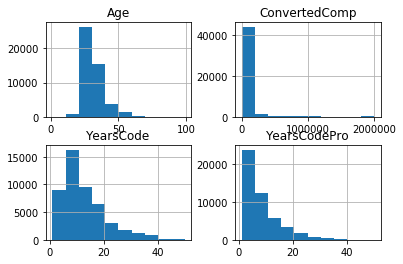

In [8]:
df.hist();

This didn't tell us much.
What we know:
* Salary variance seems low. We'll confirm this matematically.
* We have a good distribution of people coding throughout many years and an OK age group distribution.

In [9]:
# So let's see about salary distribution:
df.ConvertedComp.describe()
# count    5.036400e+04
# mean     1.268866e+05
# std      2.842949e+05
# min      0.000000e+00
# 25%      2.565600e+04
# 50%      5.728700e+04
# 75%      1.000000e+05
# max      2.000000e+06

df.ConvertedComp.median()
# 57287.0

57287.0

We have null salaries, so that is sweking the data.

Let's remove those.

In [10]:
df_real = df[df.ConvertedComp > 0]
df_real

,Age,Gender,Dependents,Country,ConvertedComp,YearsCode,Age1stCode,YearsCodePro,MainBranch,DevType,Employment,EdLevel,UndergradMajor,EduOther
3,22.0,Man,No,United States,61000.0,3,16,1,I am a developer by profession,"Developer, full-stack",Employed full-time,"Bachelor’s degree (BA, BS, B.Eng., etc.)","Computer science, computer engineering, or sof...",Taken an online course in programming or softw...
8,23.0,Man,No,New Zealand,95179.0,12,11,4,I am a developer by profession,"Database administrator;Developer, back-end;Dev...",Employed full-time,Some college/university study without earning ...,"Computer science, computer engineering, or sof...",Taken an online course in programming or softw...
12,28.0,Man,Yes,United States,90000.0,17,11,8,I am a developer by profession,Data or business analyst;Database administrato...,Employed full-time,"Master’s degree (MA, MS, M.Eng., MBA, etc.)","Computer science, computer engineering, or sof...",Taken an online course in programming or softw...
13,31.0,Man,No,Germany,57060.0,13,16,2,I am a developer by profession,"Developer, desktop or enterprise applications",Employed full-time,"Other doctoral degree (Ph.D, Ed.D., etc.)","Computer science, computer engineering, or sof...",Completed an industry certification program (e...
15,26.0,Man,No,United Kingdom,455352.0,10,17,3,I am a developer by profession,"Developer, full-stack",Employed full-time,"Master’s degree (MA, MS, M.Eng., MBA, etc.)",NaN,Taken an online course in programming or softw...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
88324,48.0,Man,Yes,United States,2000000.0,31,18,28,I am a developer by profession,Data scientist or machine learning specialist;...,Employed full-time,"Bachelor’s degree (BA, BS, B.Eng., etc.)","Computer science, computer engineering, or sof...",Taken an online course in programming or softw...
88325,26.0,Man,No,United States,130000.0,12,14,3,I am a developer by profession,"Developer, back-end;Developer, front-end;Devel...",Employed full-time,"Bachelor’s degree (BA, BS, B.Eng., etc.)","Computer science, computer engineering, or sof...",Taken an online course in programming or softw...
88326,34.0,Man,No,Finland,82488.0,17,16,7,I am a developer by profession,"Developer, desktop or enterprise applications;...",Employed full-time,"Master’s degree (MA, MS, M.Eng., MBA, etc.)","Computer science, computer engineering, or sof...","Taught yourself a new language, framework, or ..."
88328,37.0,Man,No,Austria,68745.0,18,17,9,I am a developer by profession,"Developer, full-stack;Engineer, site reliability",Employed full-time,"Master’s degree (MA, MS, M.Eng., MBA, etc.)","Computer science, computer engineering, or sof...",Taken an online course in programming or softw...


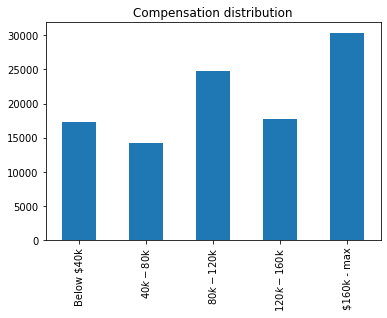

In [11]:
# Count individual replies (we need to clean a few things first, otherwise we get too much results!):
comp_40 = df_real[df_real.ConvertedComp < 40000].ConvertedComp.count()
comp_80 = df_real[df_real.ConvertedComp < 80000].ConvertedComp.count() - comp_40
comp_120 = df_real[df_real.ConvertedComp < 120000].ConvertedComp.count() - comp_80
comp_160 = df_real[df_real.ConvertedComp < 160000].ConvertedComp.count() - comp_120
comp_200 = df_real[df_real.ConvertedComp < 99999999].ConvertedComp.count() - comp_160

possible_values = ["Below $40k", "$40k - $80k", "$80k - $120k", "$120k - $160k", "$160k - max"];
comp_values = pd.DataFrame([comp_40, comp_80, comp_120, comp_160, comp_200]);

# study = df['ConvertedComp'].value_counts().reset_index()
# study.rename(columns={'index': 'Compensation', 'ConvertedComp': 'count'}, inplace=True)

(comp_values).plot(kind="bar", legend=None); # / df.ConvertedComp.count()
plt.title("Compensation distribution");
plt.xticks([0, 1, 2, 3, 4], possible_values);

Right. So we do have significant responses for salary and a good distribution throughout.

How about how each feature is correlated to one another. Ideally we'd like to see a good correlation with some of the selected features so we could predict salary based on years of experience.

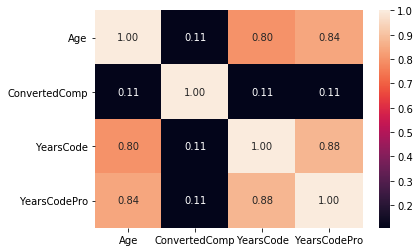

In [12]:
sns.heatmap(df_real.corr(), annot=True, fmt=".2f")

Intuitively this does not feel!
What we get from this is that Years of Coding / Professionally have no correlation to the actual developer salary.

In [13]:
df_real.sort_values(by=['YearsCode'])

,Age,Gender,Dependents,Country,ConvertedComp,YearsCode,Age1stCode,YearsCodePro,MainBranch,DevType,Employment,EdLevel,UndergradMajor,EduOther
41107,45.0,Man,Yes,United States,2000000.0,1,Younger than 5 years,1,I am a developer by profession,Data scientist or machine learning specialist;...,"Independent contractor, freelancer, or self-em...","Professional degree (JD, MD, etc.)","Computer science, computer engineering, or sof...",Taken an online course in programming or softw...
48356,21.0,Man,No,Iran,2280.0,1,15,1,I am a developer by profession,"Designer;Developer, embedded applications or d...",Employed full-time,"Bachelor’s degree (BA, BS, B.Eng., etc.)","Computer science, computer engineering, or sof...",NaN
36329,36.0,Man,No,United States,70000.0,1,24,1,I am a developer by profession,"Developer, full-stack",Employed full-time,"Bachelor’s degree (BA, BS, B.Eng., etc.)","A business discipline (ex. accounting, finance...",Taken an online course in programming or softw...
48317,24.0,Man,Yes,India,9795.0,1,14,1,I am a developer by profession,"Developer, full-stack",Employed full-time,"Bachelor’s degree (BA, BS, B.Eng., etc.)","Computer science, computer engineering, or sof...",Taken an online course in programming or softw...
59971,28.0,Woman,No,Spain,29.0,1,15,1,I am a developer by profession,"Developer, front-end",Employed full-time,"Master’s degree (MA, MS, M.Eng., MBA, etc.)",Fine arts or performing arts (ex. graphic desi...,Participated in a full-time developer training...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49373,60.0,Man,No,United Kingdom,34020.0,50,11,39,I am a developer by profession,Data or business analyst;Database administrato...,"Independent contractor, freelancer, or self-em...","Bachelor’s degree (BA, BS, B.Eng., etc.)",NaN,Taken an online course in programming or softw...
25520,65.0,NaN,No,Bangladesh,5100.0,50,Younger than 5 years,50,I am a developer by profession,NaN,NaN,"Other doctoral degree (Ph.D, Ed.D., etc.)",Fine arts or performing arts (ex. graphic desi...,NaN
50557,68.0,Man,No,United States,115000.0,50,18,50,I am a developer by profession,"Developer, desktop or enterprise applications",Employed full-time,"Master’s degree (MA, MS, M.Eng., MBA, etc.)","Another engineering discipline (ex. civil, ele...",Taken an online course in programming or softw...
24484,70.0,Man,Yes,United States,115000.0,50,17,50,I am a developer by profession,Data or business analyst;Database administrato...,"Independent contractor, freelancer, or self-em...",I never completed any formal education,NaN,Taken an online course in programming or softw...


We can see why this result shows up by simply observing some values (as above)

Even within 1 year of coding the salaries are ultra varied ranging from low to high.
But this hides another issue with our data: multiple countries and economies!

And weird data entries where data is too low.
For instance: Spain and Portugal have respondents with yearly Salaries < 100. **That doesn't look right!**

Need to eliminate such weird values.
We need to do this by country, because: what do we consider to be a strange value?

Whilst an annual salary of 500 USD in the United States sounds ridiculous, the same may an actual figure for developing countries elsewhere in the globe.

### Intra-Summary
Years or Coding is **NOT** a good indicator (it's actually so terrible at it) to understand salary or salary progression.

This insight is compiled over all the data.

#### Let's analyse per-feature:
* Country

Let's aggregate to get per Country statistics and analyse the data from the United Kingdom:

In [0]:
df_country_sorted = df_real.sort_values(by=['Country'])

df_by_country = pd.Series();

for country in df_country_sorted.Country.unique():
   df_by_country[country] = df_country_sorted[df_country_sorted.Country == country]

# E.g. (UK considered threshold of £12,500 ~ $16000 for full time employees):
df_uk = df_by_country['United Kingdom'][df_by_country['United Kingdom'].ConvertedComp > 16000]

### Correlation and HeatMap within the UK:



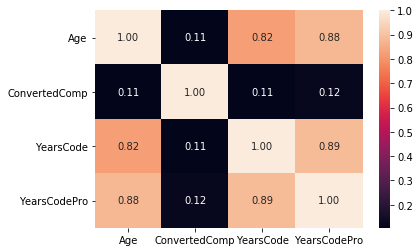

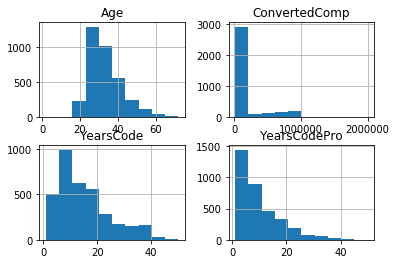

In [15]:
sns.heatmap(df_uk.corr(), annot=True, fmt=".2f")
df_uk.hist();

Nothing changed with relation to Salary towards Years of Coding / Professionally.

### 1-Summary

StackOverflow data does allow us to make conclusions on the expected salary for years of service. Not at a macro level and potentially not at a local level either. We've only verified the local level for the UK, which is a developer hotspot.


# 2. Where are the cheapest developers?

We start out by reloading the data:

In [29]:
df = pd.read_csv('drive/My Drive/Colab Notebooks/survey_results_public.csv')

# Dropping 2 non-respondents:
df = df.dropna(axis=0, how="any", subset=['MainBranch'])

# Dropping types of coders but the professional, current or past:
df = df[df.MainBranch != "I am a student who is learning to code"]
df = df[df.MainBranch != "I am not primarily a developer, but I write code sometimes as part of my work"]
df = df[df.MainBranch != "I code primarily as a hobby"]

# Dropping responses if they do not include salary, country, years of coding nor information about their language/experience:
df = df.dropna(axis=0, how="any", subset=['Country', 'ConvertedComp', 'YearsCode', 'YearsCodePro', 'LanguageWorkedWith', 'DatabaseWorkedWith', 'PlatformWorkedWith', 'WebFrameWorkedWith', 'MiscTechWorkedWith', 'OpSys'])
df = df[df.ConvertedComp > 0]
df = df[df.Age > 16]

df

,Respondent,MainBranch,Hobbyist,OpenSourcer,OpenSource,Employment,Country,Student,EdLevel,UndergradMajor,EduOther,OrgSize,DevType,YearsCode,Age1stCode,YearsCodePro,CareerSat,JobSat,MgrIdiot,MgrMoney,MgrWant,JobSeek,LastHireDate,LastInt,FizzBuzz,JobFactors,ResumeUpdate,CurrencySymbol,CurrencyDesc,CompTotal,CompFreq,ConvertedComp,WorkWeekHrs,WorkPlan,WorkChallenge,WorkRemote,WorkLoc,ImpSyn,CodeRev,CodeRevHrs,...,DatabaseWorkedWith,DatabaseDesireNextYear,PlatformWorkedWith,PlatformDesireNextYear,WebFrameWorkedWith,WebFrameDesireNextYear,MiscTechWorkedWith,MiscTechDesireNextYear,DevEnviron,OpSys,Containers,BlockchainOrg,BlockchainIs,BetterLife,ITperson,OffOn,SocialMedia,Extraversion,ScreenName,SOVisit1st,SOVisitFreq,SOVisitTo,SOFindAnswer,SOTimeSaved,SOHowMuchTime,SOAccount,SOPartFreq,SOJobs,EntTeams,SOComm,WelcomeChange,SONewContent,Age,Gender,Trans,Sexuality,Ethnicity,Dependents,SurveyLength,SurveyEase
8,9,I am a developer by profession,Yes,Once a month or more often,The quality of OSS and closed source software ...,Employed full-time,New Zealand,No,Some college/university study without earning ...,"Computer science, computer engineering, or sof...",Taken an online course in programming or softw...,10 to 19 employees,"Database administrator;Developer, back-end;Dev...",12,11,4,Slightly satisfied,Slightly satisfied,Somewhat confident,No,Not sure,"I’m not actively looking, but I am open to new...",Less than a year ago,Write any code;Interview with people in peer r...,Yes,Financial performance or funding status of the...,I was preparing for a job search,NZD,New Zealand dollar,138000.0,Yearly,95179.0,32.0,There is a schedule and/or spec (made by me or...,Being tasked with non-development work;Inadequ...,Less than once per month / Never,Office,A little above average,"Yes, because I see value in code review",12.0,...,DynamoDB;PostgreSQL;SQLite,PostgreSQL;Redis;SQLite,AWS;Docker;Heroku;Linux;MacOS;Slack,AWS;Docker;Heroku;Linux;MacOS;Slack;Other(s):,Express;Ruby on Rails;Other(s):,Express;Ruby on Rails;Other(s):,Node.js;Unity 3D,Node.js,Vim,MacOS,Development;Testing;Production,Not at all,An irresponsible use of resources,No,SIGH,Yes,Twitter,In real life (in person),Username,2013,Daily or almost daily,Find answers to specific questions;Contribute ...,3-5 times per week,They were about the same,NaN,Yes,Less than once per month or monthly,"No, I knew that Stack Overflow had a job board...","No, and I don't know what those are","Yes, somewhat",Just as welcome now as I felt last year,NaN,23.0,Man,No,Bisexual,White or of European descent,No,Appropriate in length,Neither easy nor difficult
12,13,I am a developer by profession,Yes,Less than once a month but more than once per ...,"OSS is, on average, of HIGHER quality than pro...",Employed full-time,United States,No,"Master’s degree (MA, MS, M.Eng., MBA, etc.)","Computer science, computer engineering, or sof...",Taken an online course in programming or softw...,10 to 19 employees,Data or business analyst;Database administrato...,17,11,8,Very satisfied,Very satisfied,NaN,NaN,NaN,I am not interested in new job opportunities,3-4 years ago,Complete a take-home project;Interview with pe...,Yes,"Languages, frameworks, and other technologies ...",I was preparing for a job search,USD,United States dollar,90000.0,Yearly,90000.0,40.0,There is a schedule and/or spec (made by me or...,"Meetings;Non-work commitments (parenting, scho...",All or almost all the time (I'm full-time remote),Home,A little above average,"Yes, because I see value in code review",5.0,...,Couchbase;DynamoDB;Firebase;MySQL,Firebase;MySQL;Redis,Android;AWS;Docker;IBM Cloud or Watson;iOS;Lin...,Android;AWS;Docker;IBM Cloud or Watson;Linux;S...,Angular/Angular.js;ASP.NET;Express;jQuery;Vue.js,Express;Vue.js,Node.js;Xamarin,Node.js;TensorFlow,Vim;Visual Studio;Visual Studio Code;Xcode,Windows,Development;Testing;Production,Not at all,"Useful for decentralized currency (i.e., Bitcoin)",Yes,Yes,Yes,Twitter,In real life (in person),Username,2

In [17]:
df_by_country = pd.Series();

for country in df.Country.unique():
   df_by_country[country] = df[df.Country == country]

# E.g. (UK considered threshold of £12,500 ~ $16000 for full time employees):
df_uk = df_by_country['United Kingdom'][df_by_country['United Kingdom'].ConvertedComp > 16000]

# Example:
df_uk

,Respondent,MainBranch,Hobbyist,OpenSourcer,OpenSource,Employment,Country,Student,EdLevel,UndergradMajor,EduOther,OrgSize,DevType,YearsCode,Age1stCode,YearsCodePro,CareerSat,JobSat,MgrIdiot,MgrMoney,MgrWant,JobSeek,LastHireDate,LastInt,FizzBuzz,JobFactors,ResumeUpdate,CurrencySymbol,CurrencyDesc,CompTotal,CompFreq,ConvertedComp,WorkWeekHrs,WorkPlan,WorkChallenge,WorkRemote,WorkLoc,ImpSyn,CodeRev,CodeRevHrs,...,DatabaseWorkedWith,DatabaseDesireNextYear,PlatformWorkedWith,PlatformDesireNextYear,WebFrameWorkedWith,WebFrameDesireNextYear,MiscTechWorkedWith,MiscTechDesireNextYear,DevEnviron,OpSys,Containers,BlockchainOrg,BlockchainIs,BetterLife,ITperson,OffOn,SocialMedia,Extraversion,ScreenName,SOVisit1st,SOVisitFreq,SOVisitTo,SOFindAnswer,SOTimeSaved,SOHowMuchTime,SOAccount,SOPartFreq,SOJobs,EntTeams,SOComm,WelcomeChange,SONewContent,Age,Gender,Trans,Sexuality,Ethnicity,Dependents,SurveyLength,SurveyEase
93,94,I am a developer by profession,Yes,Never,"OSS is, on average, of HIGHER quality than pro...",Employed full-time,United Kingdom,No,Some college/university study without earning ...,"Computer science, computer engineering, or sof...",Received on-the-job training in software devel...,2-9 employees,"Database administrator;Designer;Developer, bac...",7,16,5,Neither satisfied nor dissatisfied,Slightly dissatisfied,Not at all confident,Yes,I am already a manager,"I’m not actively looking, but I am open to new...",3-4 years ago,"Write any code;Write code by hand (e.g., on a ...",Yes,Opportunities for professional development;How...,I was preparing for a job search,GBP,Pound sterling,33000.0,Yearly,43180.0,44.0,There is a schedule and/or spec (made by me or...,Being tasked with non-development work;Inadequ...,A few days each month,Home,A little above average,"Yes, because I see value in code review",2.0,...,Microsoft SQL Server,Microsoft SQL Server,Microsoft Azure;Windows,Android;Arduino;Microsoft Azure;Raspberry Pi;W...,ASP.NET;jQuery,ASP.NET;jQuery,.NET;.NET Core;Node.js,.NET;.NET Core;Node.js;Unity 3D;Unreal Engine;...,Notepad++;Visual Studio;Visual Studio Code,Windows,I do not use containers,Not at all,Useful for immutable record keeping outside of...,Yes,SIGH,Yes,Reddit,Online,Username,2013,Multiple times per day,Find answers to specific questions;Learn how t...,More than 10 times per week,Stack Overflow was slightly faster,31-60 minutes,No,NaN,"No, I knew that Stack Overflow had a job board...","No, and I don't know what those are","No, not really",Just as welcome now as I felt last year,NaN,27.0,Man,No,Straight / Heterosexual,White or of European descent,No,Appropriate in length,Easy
162,164,I am a developer by profession,Yes,Never,The quality of OSS and closed source software ...,Employed full-time,United Kingdom,No,"Bachelor’s degree (BA, BS, B.Eng., etc.)","Computer science, computer engineering, or sof...",Taken an online course in programming or softw...,"5,000 to 9,999 employees","Developer, full-stack",23,10,20,Very satisfied,Slightly satisfied,Very confident,No,Not sure,I am not interested in new job opportunities,More than 4 years ago,Interview with people in senior / management r...,No,"Languages, frameworks, and other technologies ...",I heard about a job opportunity (from a recrui...,GBP,Pound sterling,48000.0,Yearly,62807.0,38.0,There is a schedule and/or spec (made by me or...,Being tasked with non-development work;Not eno...,A few days each month,Home,Average,"Yes, because I see value in code review",2.0,...,Microsoft SQL Server,MongoDB;Microsoft SQL Server,Raspberry Pi;WordPress,Android;Arduino;Docker;Kubernetes;Microsoft Az...,ASP.NET;jQuery;Vue.js,ASP.NET;jQuery;React.js;Vue.js,.NET;.NET Core,.NET;.NET Core;React Native;Unity 3D;Xamarin,Notepad++;Visual Studio;Visual Studio Code,Windows,I do not use containers,NaN,NaN,Yes,Yes,Yes,YouTube,Online,Username,2012,A few times per week,Find answers to specific questions,1-2 times per week,They were about the same,NaN,Yes,Less than once per month or monthly,Yes,"No, 

Let's analyse the bigger picture distribution and eliminate the countries where we have a limited number of replies ( < 1% of total responses).

In [169]:
df.Country.fillna(value=0, axis=0, inplace=True);

res = df['Country'].value_counts()

res = df.groupby(['Country']).ConvertedComp.mean().sort_values()
res
# df[df.JobSatisfaction > 9.0]['EmploymentStatus'].value_counts() / df.EmploymentStatus[df.EmploymentStatus.isnull() == False].value_counts()

Country
Guinea                    1956.000000
Syrian Arab Republic      2214.000000
Sudan                     3355.428571
Burundi                   3606.000000
Madagascar                4074.000000
                            ...      
Ireland                 252481.055901
United States           253460.706250
Swaziland               284296.000000
Qatar                   306967.000000
Liechtenstein           811188.000000
Name: ConvertedComp, Length: 148, dtype: float64

Lowest average salaries are in **Guinea**.

# 3. How well can we predict Salary based on Country?

First we need to transform the Country categorical data for analysis.


In [229]:
df = pd.read_csv('drive/My Drive/Colab Notebooks/survey_results_public.csv')

# Dropping 2 non-respondents:
df = df.dropna(axis=0, how="any", subset=['MainBranch'])

# Dropping types of coders but the professional, current or past:
df = df[df.MainBranch != "I am a student who is learning to code"]
df = df[df.MainBranch != "I am not primarily a developer, but I write code sometimes as part of my work"]
df = df[df.MainBranch != "I code primarily as a hobby"]

# Dropping responses if they do not include salary, country, years of coding nor information about their language/experience:
df = df.dropna(axis=0, how="any", subset=['Country', 'ConvertedComp'])
df = df[df.ConvertedComp > 0]
df = df[df.Age > 16]

df = df[['ConvertedComp', 'Country']]
df

,ConvertedComp,Country
3,61000.0,United States
8,95179.0,New Zealand
12,90000.0,United States
13,57060.0,Germany
15,455352.0,United Kingdom
...,...,...
88324,2000000.0,United States
88325,130000.0,United States
88326,82488.0,Finland
88328,68745.0,Austria


Let's check the correlation between country and salaries.

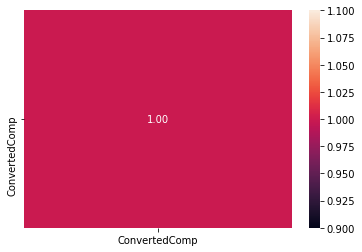

In [232]:
sns.heatmap(df.corr(), annot=True, fmt=".2f");

In [233]:
countries = df.Country.unique()
columns = np.append(countries, ['ConvertedComp'])

d = pd.get_dummies(data=df, columns=['Country'], drop_first=False, prefix='', prefix_sep='')
d = d[columns]
d

,United States,New Zealand,Germany,United Kingdom,Australia,Brazil,Israel,South Africa,Switzerland,Argentina,Czech Republic,Spain,Serbia,India,Poland,Sweden,China,Netherlands,Philippines,Ireland,Pakistan,Austria,Canada,Croatia,Russian Federation,Italy,Turkey,Romania,Finland,Viet Nam,Iran,Hungary,Latvia,Hong Kong (S.A.R.),United Arab Emirates,France,Bulgaria,Nicaragua,Denmark,Japan,...,Saudi Arabia,Swaziland,Cyprus,"Congo, Republic of the...",Zambia,Bahrain,Timor-Leste,Jamaica,Myanmar,Djibouti,Libyan Arab Jamahiriya,Togo,Cambodia,Côte d'Ivoire,Iraq,Sudan,Burundi,Barbados,Lesotho,Qatar,Tajikistan,Botswana,Madagascar,Burkina Faso,Somalia,Fiji,Oman,Andorra,Haiti,Mozambique,Maldives,Saint Vincent and the Grenadines,San Marino,Democratic Republic of the Congo,Lao People's Democratic Republic,Malawi,Democratic People's Republic of Korea,Chad,Mali,ConvertedComp
3,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,61000.0
8,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,95179.0
12,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,90000.0
13,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,57060.0
15,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,455352.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
88324,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2000000.0
88325,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,130000.0
88326,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,82488.0
88328,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,68745.0


In [256]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error

X = d[countries]
y = d['ConvertedComp']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .30, random_state=42)

lm_model = LinearRegression(normalize=True) 

try:
    lm_model.fit(X_train, y_train)
except:
    print("Oh no! It doesn't work!!!")

y_test_preds = lm_model.predict(X_test) # Predictions here using X_train,y_train and lm_model
r2_test =  r2_score(y_test, y_test_preds) # Rsquared here for comparing test and preds from lm_model
r2_test

-1.5807239736071025e+22

## 3. The answer is: we cannot predict salary based on the developer's country.

This feels intuitive since whithin each geography there will be plenty of developers and each at different stages of careers and expertise. Thus, being compensated differently.